In [1]:
# Scientific and vector computation for python
import numpy as np

# Data analysis and manipulation tool for python
import pandas as pd

# Plotting library
import matplotlib.pyplot as plt 

# Unlike Assignment 1 that only uses basic libraries, 
# Assignment 2 utilizes sckit-learn libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn import tree
from sklearn.feature_extraction import DictVectorizer
from src import *


%matplotlib inline

In [2]:
# Load Data
raw_classification_data = pd.read_csv("train.csv")
#raw_classification_data.drop('Unnamed: 0', axis=1, inplace=True)
raw_classification_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    object 
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     891 non-null    object 
dtypes: float64(2), int64(4), object(6)
memory usage: 83.7+ KB


In [3]:
#Remove Ticket
raw_classification_data = raw_classification_data.drop(columns=['Ticket'])


#Retain surname but not name
raw_classification_data['LastName'] = raw_classification_data['Name'].str.split(',').str.get(0)
raw_classification_data = raw_classification_data.drop(columns=['Name'])


#Spliting Cabin into area and num
cabin_parts = raw_classification_data['Cabin'].str.extract(r'([A-Za-z]+)(\d+)')
raw_classification_data['Cabin_area'] = cabin_parts[0]


# If you need 'Cabin_num' to be numeric, you can convert it
raw_classification_data = raw_classification_data.drop(columns=['Cabin', 'PassengerId', 'Embarked'])

raw_classification_data['Cabin_area'] = raw_classification_data['Cabin_area'].fillna("N")

grouped_means = raw_classification_data.groupby(['Sex', 'Pclass'])['Age'].mean().reset_index()

# Merge the mean ages with the original data using the 'Sex' and 'Pclass' columns
raw_classification_data = raw_classification_data.merge(
    grouped_means,
    on=['Sex', 'Pclass'],
    how='left',
    suffixes=('', '_mean')
)

# Fill the missing values in 'Age' with the corresponding 'Age_mean' values
raw_classification_data['Age'] = raw_classification_data.apply(
    lambda row: row['Age_mean'] if pd.isnull(row['Age']) else row['Age'],
    axis=1
)

# Drop the 'Age_mean' column as it's no longer needed
raw_classification_data.drop('Age_mean', axis=1, inplace=True)


raw_classification_data.head()

Survived  Pclass     Sex   Age  SibSp  Parch     Fare   LastName Cabin_area
0     Dead       3    male  22.0      1      0   7.2500     Braund          N
1  Survive       1  female  38.0      1      0  71.2833    Cumings          C
2  Survive       3  female  26.0      0      0   7.9250  Heikkinen          N
3  Survive       1  female  35.0      1      0  53.1000   Futrelle          C
4     Dead       3    male  35.0      0      0   8.0500      Allen          N

Attribute Number: 9


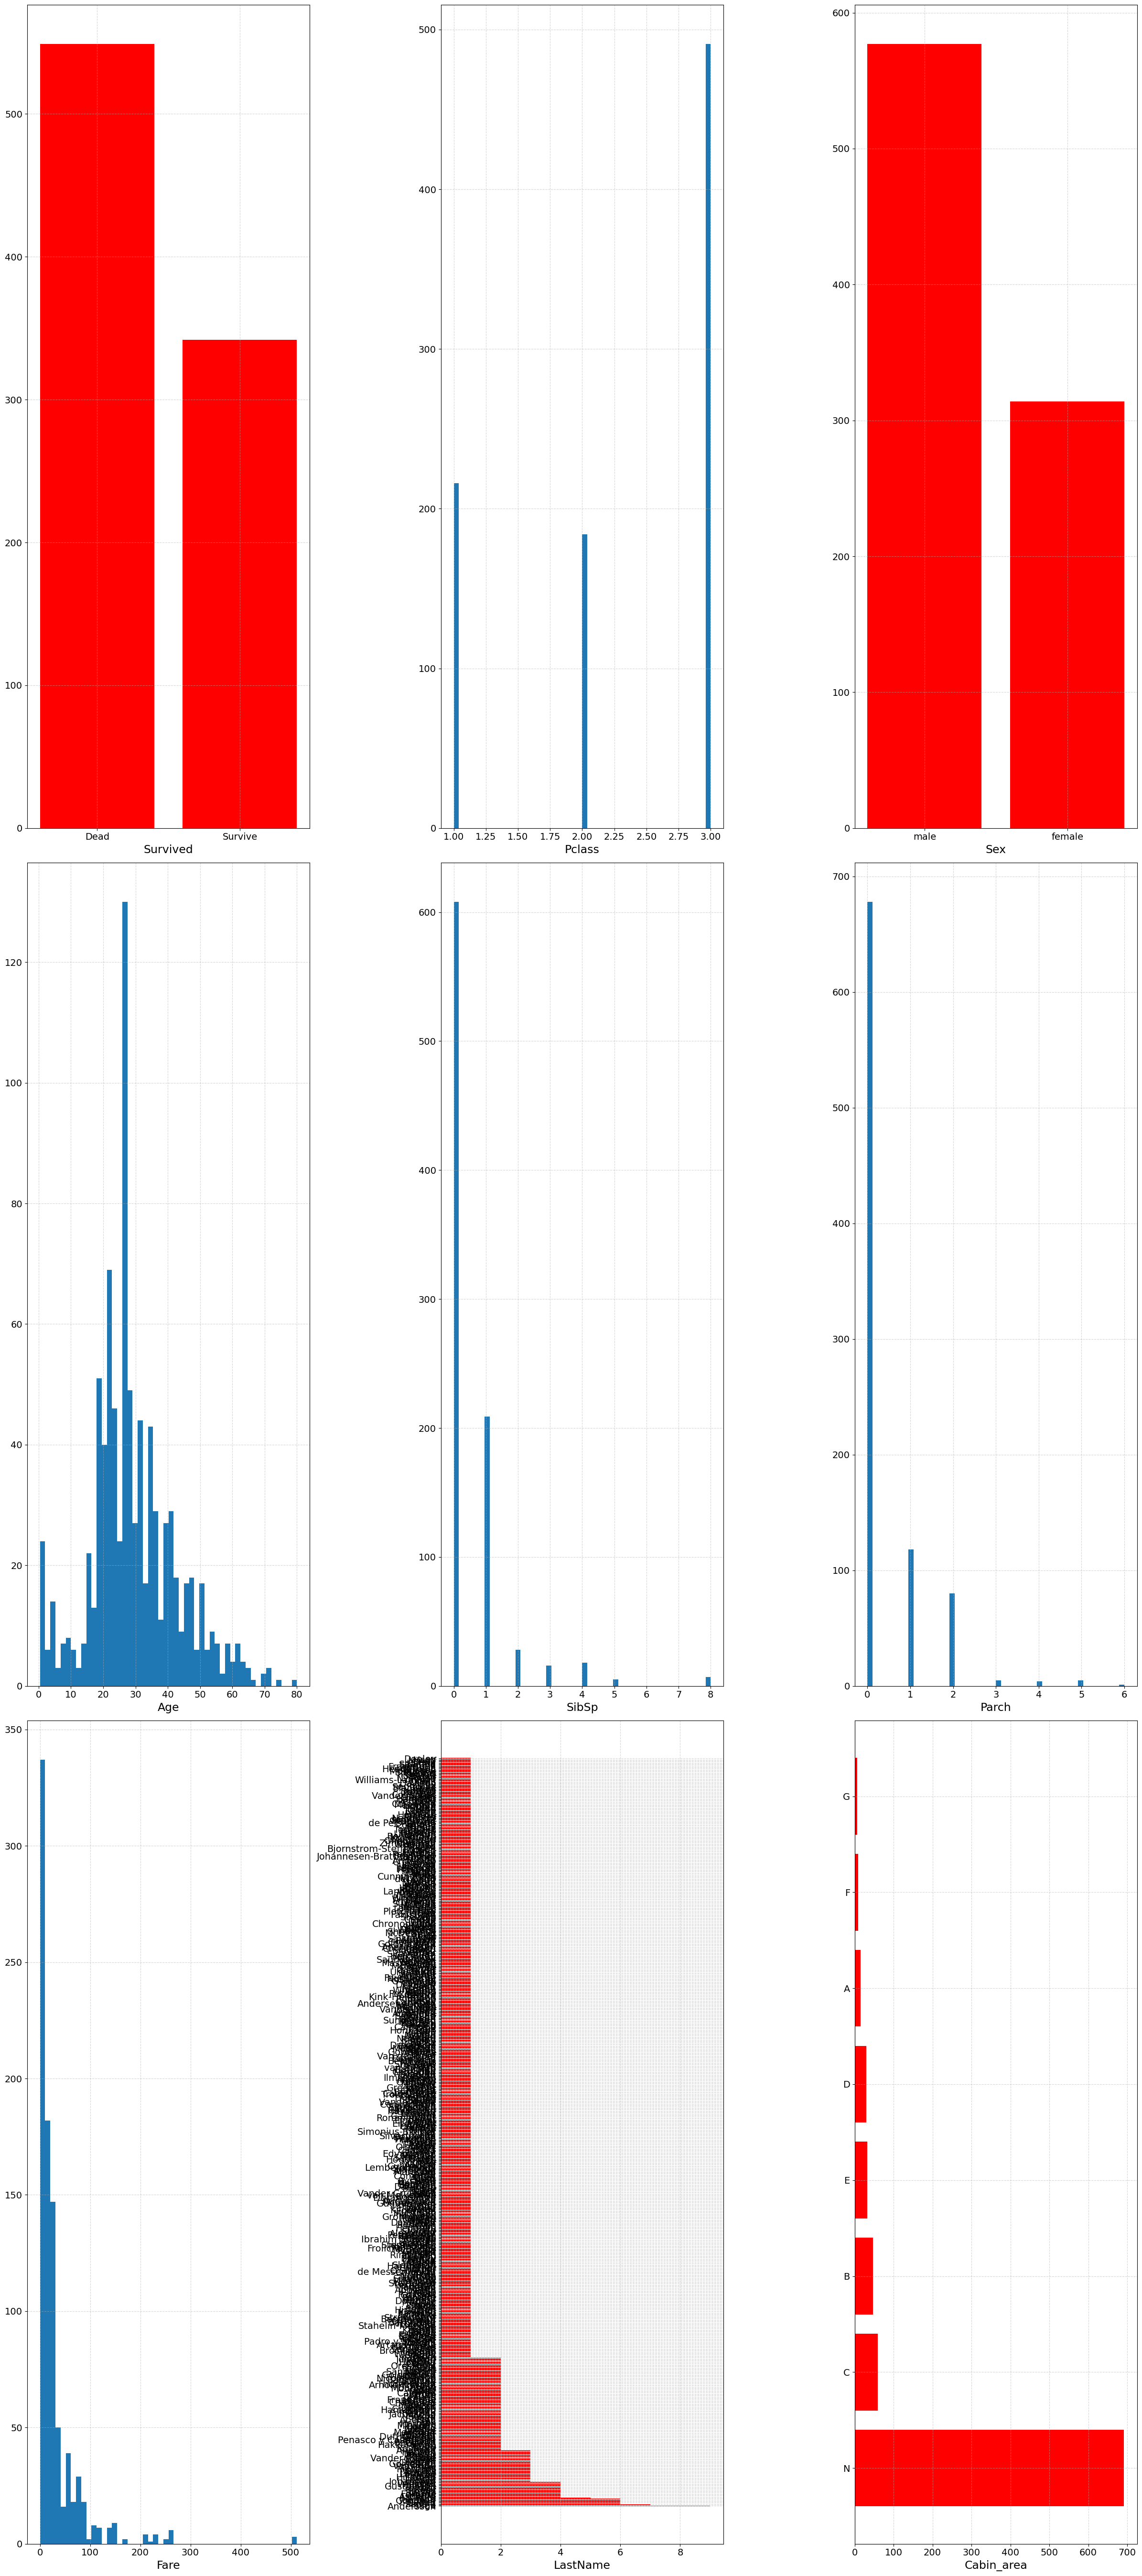

In [4]:
attribute_number = len(raw_classification_data.columns)
print("Attribute Number: {}".format(attribute_number))

# subplots 
fig = plt.figure(figsize=(24, 54))
ax = fig.subplots(attribute_number//3,3)
# iterations
for num, title in enumerate(raw_classification_data.columns):
    idx = num//3 # divided with no remainder
    idy = num%3  # remainder 
    if raw_classification_data[title].dtype in ['object']:
        value_count_dict = raw_classification_data[title].value_counts().to_dict()
        keys = list(value_count_dict.keys())
        values = list(value_count_dict.values())
        if len(raw_classification_data[title].unique().tolist()) < 8:
            ax[idx, idy].bar(keys, values, color='r')
        else:
            ax[idx, idy].barh(keys, values, color='r')
    else:
        ax[idx, idy].hist(raw_classification_data[title].values, bins=50);
    
    # set title with attribute
    ax[idx, idy].set_xlabel(title, fontsize=17)
    # set grid width
    ax[idx, idy].grid(linestyle='--', alpha=0.5)
    # font size of ticks
    ax[idx, idy].tick_params(labelsize=14)
plt.tight_layout()

In [5]:
raw_classification_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 0 to 890
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Survived    891 non-null    object 
 1   Pclass      891 non-null    int64  
 2   Sex         891 non-null    object 
 3   Age         891 non-null    float64
 4   SibSp       891 non-null    int64  
 5   Parch       891 non-null    int64  
 6   Fare        891 non-null    float64
 7   LastName    891 non-null    object 
 8   Cabin_area  891 non-null    object 
dtypes: float64(2), int64(3), object(4)
memory usage: 69.6+ KB


In [6]:
# extract label name and feature name list
class_name = 'Survived'
feature_name = list(raw_classification_data.columns)
feature_name.remove(class_name)

# separate features and labels (classes)
data_y = raw_classification_data[class_name]
data_x = raw_classification_data[feature_name]

# train-test data split
x_train, x_test, y_train, y_test = train_test_split(data_x, data_y, test_size = 0.30, random_state = 25)
data_train = pd.concat([x_train, y_train], axis=1)
data_test = pd.concat([x_test, y_test], axis=1)


nan_count = data_train.isna().sum()

# Print the count of NaN values for each column that has them
print(nan_count[nan_count > 0])

Series([], dtype: int64)


In [7]:
# generate decision tree recursively 
tree_root_node = generate_tree(data_train, feature_name, class_name)
w = open('decisionTree.txt','w')
print_tree(tree_root_node, w)
w.close()

Testing accuracy with Decision Tree is 72.41379310344827 %
Confusion Matrix:
[[36 10]
 [14 27]]
              precision    recall  f1-score   support

        Dead       0.72      0.78      0.75        46
     Survive       0.73      0.66      0.69        41

    accuracy                           0.72        87
   macro avg       0.72      0.72      0.72        87
weighted avg       0.72      0.72      0.72        87



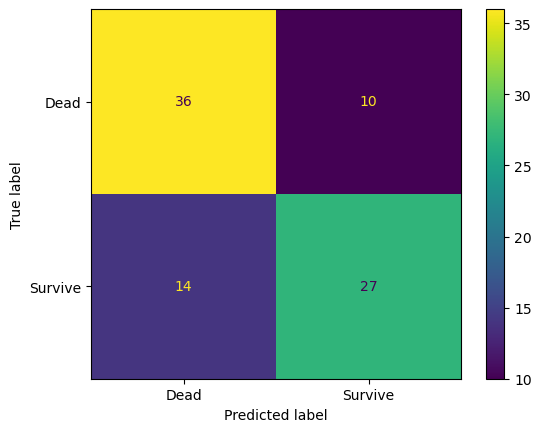

In [8]:
# performance evaluation
y_pred = np.zeros_like(y_test)


for idx in range(x_test.shape[0]):
    y_pred[idx] = tree_predict(tree_root_node, x_test.iloc[idx])


    
success_index_list = np.where(y_pred != 'Failed')[0] 
success_y_test = y_test.iloc[success_index_list]
success_y_pred = y_pred[success_index_list]

# get accuracy score
accuracy_major = accuracy_score(success_y_test, success_y_pred)
print('Testing accuracy with Decision Tree is {} %'.format(accuracy_major*100))

# confusion matrix to describe the performance of a classification model
print("Confusion Matrix:")
print(confusion_matrix(success_y_test, success_y_pred)) 
print(classification_report(success_y_test, success_y_pred))

# confusion matrix visualization
ConfusionMatrixDisplay.from_predictions(success_y_test,success_y_pred, display_labels=['Dead','Survive'])
plt.show()


In [9]:
# generate random forest
print(len(feature_name)) 

tree_number = 50
forest, tree_feature_subset = generate_forest(data_train, feature_name, class_name, tree_number)

8


['Dead' 'Dead' 'Dead' 'Survive' 'Dead' 'Dead' 'Dead' 'Dead' 'Survive'
 'Dead' 'Dead' 'Survive' 'Survive' 'Survive' 'Dead' 'Survive' 'Survive'
 'Dead' 'Survive' 'Survive' 'Dead' 'Dead' 'Dead' 'Survive' 'Dead' 'Dead'
 'Dead' 'Survive' 'Survive' 'Survive' 'Survive' 'Dead' 'Survive' 'Dead'
 'Survive' 'Dead' 'Dead' 'Survive' 'Dead' 'Dead' 'Survive' 'Survive'
 'Dead' 'Dead' 'Dead' 'Survive' 'Dead' 'Survive' 'Dead' 'Dead' 'Dead'
 'Survive' 'Survive' 'Dead' 'Dead' 'Dead' 'Dead' 'Dead' 'Survive' 'Dead'
 'Survive' 'Dead' 'Dead' 'Dead' 'Survive' 'Dead' 'Dead' 'Dead' 'Dead'
 'Dead' 'Dead' 'Dead' 'Dead' 'Survive' 'Survive' 'Survive' 'Dead' 'Dead'
 'Dead' 'Survive' 'Dead' 'Dead' 'Dead' 'Dead' 'Dead' 'Dead' 'Dead']
Testing accuracy with Random Forest is 75.86206896551724 %
              precision    recall  f1-score   support

        Dead       0.72      0.89      0.80        46
     Survive       0.83      0.61      0.70        41

    accuracy                           0.76        87
   macro avg 

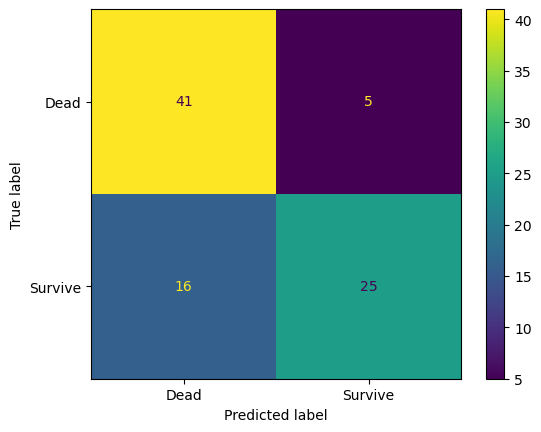

In [10]:
# performance evaluation
y_pred = np.zeros_like(y_test)
for idx in range(x_test.shape[0]):
    y_pred[idx] = forest_predict(forest, tree_feature_subset, x_test.iloc[idx])
    
success_index_list = np.where(y_pred != 'Failed')[0] 
success_y_test = y_test.iloc[success_index_list]
success_y_pred = y_pred[success_index_list]

print(success_y_pred)
# get accuracy score
accuracy_major = accuracy_score(success_y_test, success_y_pred)
print('Testing accuracy with Random Forest is {} %'.format(accuracy_major*100))

# generate a classification report
report = classification_report(success_y_test, success_y_pred)
print(report)

# confusion matrix visualization
ConfusionMatrixDisplay.from_predictions(success_y_test, success_y_pred, display_labels=['Dead', 'Survive'])
plt.show()


760       Dead
773       Dead
266       Dead
507    Survive
524       Dead
        ...   
111       Dead
271    Survive
605       Dead
580    Survive
659       Dead
Name: Survived, Length: 268, dtype: object
Testing accuracy with Random Forest is 73.50746268656717 %
              precision    recall  f1-score   support

        Dead       0.71      0.96      0.82       165
     Survive       0.86      0.37      0.52       103

    accuracy                           0.74       268
   macro avg       0.79      0.67      0.67       268
weighted avg       0.77      0.74      0.70       268



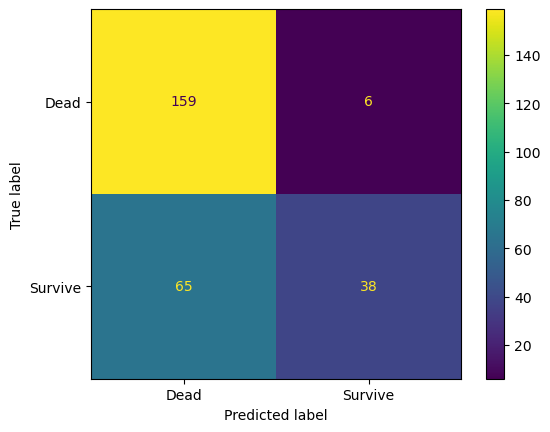

In [12]:
parameter_range = np.arange(10, 100, 10)
test_num = 10
performance_data = np.zeros((parameter_range.shape[0], test_num))

for i, tree_num in enumerate(parameter_range):
    for j in range(test_num):
        # generate random forest using decision trees using scikit-learn
        forest2, feature_vector = generate_forest_scikit(data_train, feature_name, class_name, tree_num)
        # performance evaluation
        y_pred = np.zeros_like(y_test)
        for idx in range(x_test.shape[0]):
            y_pred[idx] = forest_predict_scikit(forest2, feature_vector, x_test.iloc[idx])

        success_index_list = np.where(y_pred != 'Failed')[0] 
        success_y_test = y_test.iloc[success_index_list]
        success_y_pred = y_pred[success_index_list].astype('str')

        # get accuracy score
        accuracy_major = accuracy_score(success_y_test, success_y_pred)
        performance_data[i, j] = accuracy_major
        
        


print(success_y_test)
# get accuracy score
accuracy_major = accuracy_score(success_y_test, success_y_pred)
print('Testing accuracy with Random Forest is {} %'.format(accuracy_major*100))

# generate a classification report
report = classification_report(success_y_test, success_y_pred)
print(report)

# confusion matrix visualization
ConfusionMatrixDisplay.from_predictions(success_y_test, success_y_pred, display_labels=['Dead', 'Survive'])
plt.show()

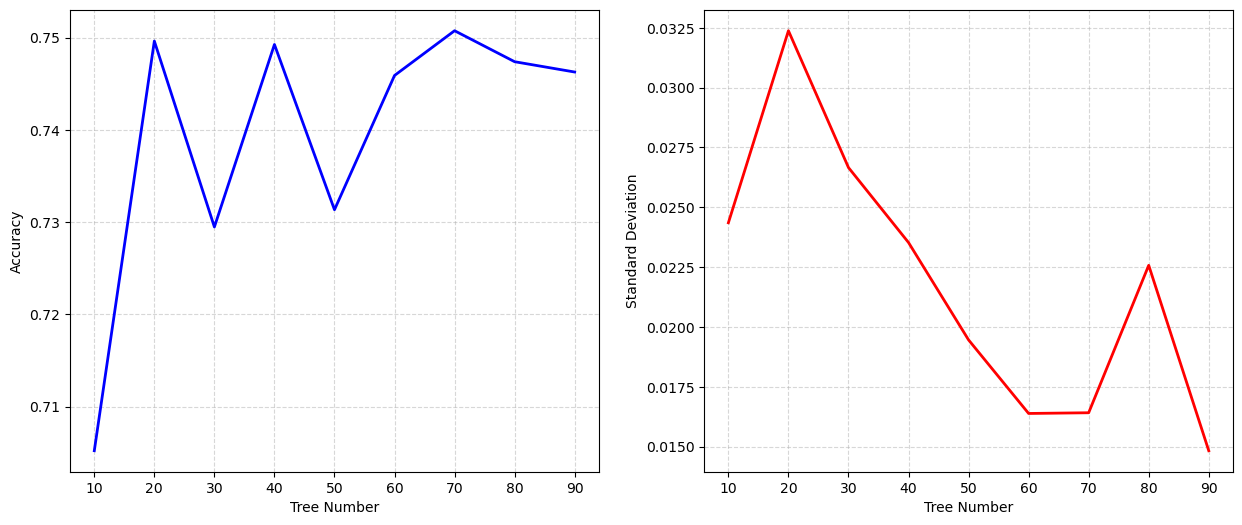

In [13]:
# visualize the performance increase
fig = plt.figure(figsize=(15, 6))
(ax1, ax2) = fig.subplots(1, 2)
ax1.plot(parameter_range, np.mean(performance_data, axis=1), color='b', linewidth=2)
ax1.set_xlabel("Tree Number")
ax1.set_ylabel("Accuracy")
ax1.grid(linestyle='--', alpha=0.5)

ax2.plot(parameter_range, np.std(performance_data, axis=1), color='r', linewidth=2)
ax2.set_xlabel("Tree Number")
ax2.set_ylabel("Standard Deviation")
ax2.grid(linestyle='--', alpha=0.5)

In [14]:
small_forest, small_feature_vector = generate_forest_scikit(data_train, feature_name, class_name, 5)

forest_fig = plt.figure(figsize=(250, 150))
ax = forest_fig.subplots(len(small_forest), 1);
for idx, (tree_node, vec) in enumerate(zip(small_forest, small_feature_vector)):
    tree.plot_tree(tree_node, ax=ax[idx], feature_names=vec.feature_names_, 
                   class_names=['Dead', 'Survive'], filled=True, fontsize=8);

In [36]:
# accuracy_score, confusion_matrix, classification_report
class_name = 'Survived'
feature_name = list(raw_classification_data.columns)
feature_name.remove(class_name)

# new_sampled_data = raw_classification_data.sample(10, ignore_index=True)
sample_data_test = data_test.sample(10, ignore_index=True)
sample_x_test = sample_data_test[feature_name]

sample_y_test = np.atleast_2d(sample_data_test[class_name].values).T
sample_y_pred_dt = np.zeros_like(sample_y_test)
sample_y_pred_rf = np.zeros_like(sample_y_test)

success_idx_list = list()
for idx in range(sample_x_test.shape[0]):
    sample_y_pred_dt[idx] = tree_predict(tree_root_node, sample_x_test.loc[idx])
    sample_y_pred_rf[idx] = forest_predict_scikit(forest2, feature_vector, sample_x_test.iloc[idx])


sample_data_test['Survived_RandomForest'] = sample_y_pred_rf
sample_data_test.head(10)

Pclass     Sex        Age  SibSp  Parch     Fare    LastName Cabin_area  \
0       2    male  25.000000      0      0  13.0000    Sedgwick          N   
1       2    male  46.000000      0      0  26.0000      McKane          N   
2       2  female  24.000000      2      3  18.7500    Richards          N   
3       3  female   3.000000      3      1  21.0750     Palsson          N   
4       3    male  26.507589      0      0   7.2250       Elias          N   
5       3    male  14.000000      5      2  46.9000     Goodwin          N   
6       3    male  26.507589      0      0   7.7500      Horgan          N   
7       1  female  60.000000      1      0  75.2500      Warren          D   
8       3    male  19.000000      0      0  10.1708       Dakic          N   
9       2    male  30.740707      0      0   0.0000  Cunningham          N   

  Survived Survived_RandomForest  
0     Dead                  Dead  
1     Dead                  Dead  
2  Survive               Survive  
3     Dead                  Dead  
4     Dead                  Dead  
5     Dead                  Dead  
6     Dead                  Dead  
7  Survive               Survive  
8     Dead                  Dead  
9     Dead                  Dead